Reference:
* Sebastian Raschka, Yuxi Hayden Liu, and Vahid Mirjalili. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing Ltd, 2022.

## Introducing Stochastic Gradient Descent with Adaline -  comparing different training schemes

In [43]:
from IPython.display import Image
from IPython.display import display

display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/adaline_flowchart.png", width=700))



### Using the Iris data

In [44]:
import os
import pandas as pd

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

df.tail()

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### Plotting the Iris data

(50, 2)
(50, 2)


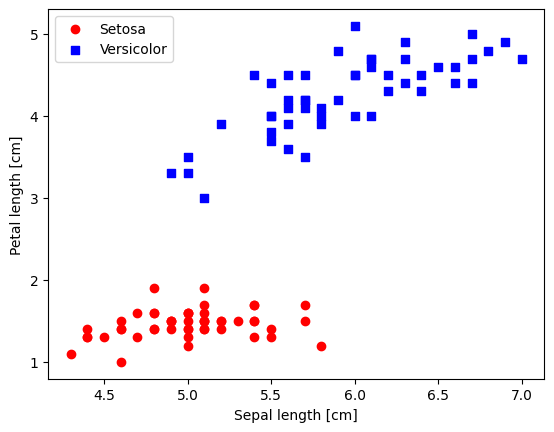

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



# select setosa and versicolor
#y = df.iloc[0:100, 4].values

y = df.iloc[:, 4].values
X = df.iloc[:, [0, 2]].values  # extract sepal length and petal length

# Map y values to 0, 1, or -1
y_mapped = np.select(
    [y == 'Iris-setosa', y == 'Iris-versicolor'],  # Conditions
    [0, 1],                                        # Values to assign if the condition is True
    default=-1                                     # Value to assign if none of the conditions are True
)


mask = (y_mapped == 0) | (y_mapped == 1)  # Mask for selecting only 0 and 1 in y_mapped


X_filtered = X[mask]
y_filtered = y_mapped[mask]


# Filter the first 50 occurrences of category 0
mask_0 = (y_filtered == 0)
X_0 = X_filtered[mask_0][:50]

# Filter the first 50 occurrences of category 1
mask_1 = (y_filtered == 1)
X_1 = X_filtered[mask_1][:50]


print(np.shape(X_0))
print(np.shape(X_1))


# plot data
plt.scatter(X_0[:, 0], X_0[:, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X_1[:, 0], X_1[:, 1],
            color='blue', marker='s', label='Versicolor')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

### Standardize Data

This can be very helpful: as we already saw, gradient descent is one of many algorithms that benefit from feature scaling.

In [46]:
X_std = np.copy(X_filtered)
X_std[:,0] = (X_filtered[:,0]-X_filtered[:,0].mean())/X_filtered[:,0].std()
X_std[:,1] = (X_filtered[:,1]-X_filtered[:,1].mean())/X_filtered[:,1].std()

### Gradient Descent Methods


1. **Gradient Descent**: (also known as batch gradient descent): updates based on entire dataset - computationally quite expensive especially for large datasets; stable updates and smooth convergence, but can be very slow. Can leverage vectorization as we saw in lecture 2.

2. **Stochastic Gradient Descent (SGD)**: updates th emodel after each individual data point; more noise/stochasticity, possibility of escaping local minima, faster updates but could lead to unstable convergence

3. **Mini-batch GD**: compromise between the above two cases; updates every mini-batch. Can leverage vectorization.



### 1. (Batch) Gradient Descent

(the following code is inherited from the previous lecture 2)

In [47]:
import numpy as np


class AdalineGD:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss values at each epoch

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)

        self.losses_ = []

        for i in range(self.n_iter):
          net_input = self.net_input(X)
          output = self.activation(net_input)
          errors = (y-output)
          # the following is vectorized
          self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0] #[n_features,n_examples]*[n_examples] = [n_features]
          self.b_ += self.eta * 2.0 * errors.mean()
          loss = (errors**2).mean()
          self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

<br>
<br>

Training the Adaline model

In [48]:
ada_gd = AdalineGD(n_iter=20, eta=0.5).fit(X_std, y_filtered)

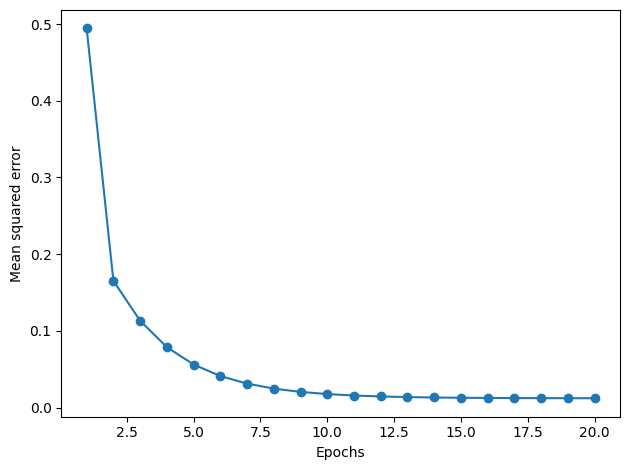

In [49]:
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')

plt.tight_layout()
plt.show()

Plotting decision regions

In [50]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

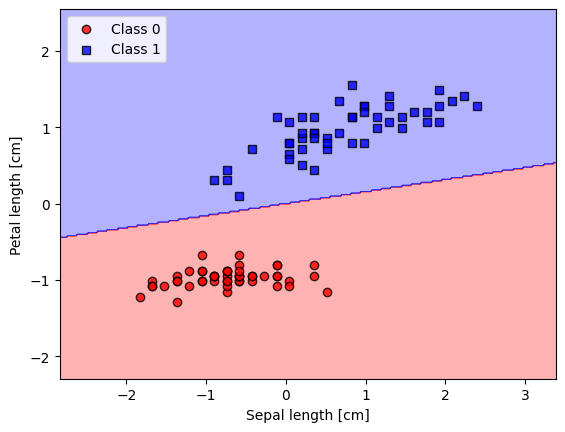

In [51]:
plot_decision_regions(X_std, y_filtered, classifier=ada_gd)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')


plt.show()

Accuracy

In [52]:
y_pred = ada_gd.predict(X_std)

accuracy = np.sum(y_pred == y_filtered) / len(y_filtered)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


### 2. Stochastic Gradient Descent

In [53]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.


    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state


    def fit(self, X, y):        #-------- this is for SGD training from scratch
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):          #-------- this is for online learning
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

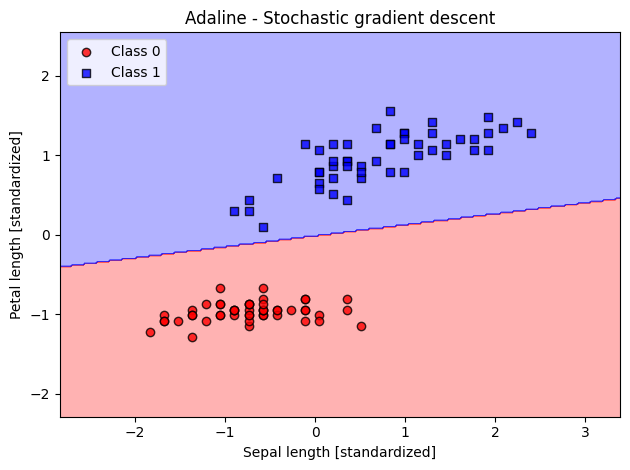

Text(0, 0.5, 'Average loss')

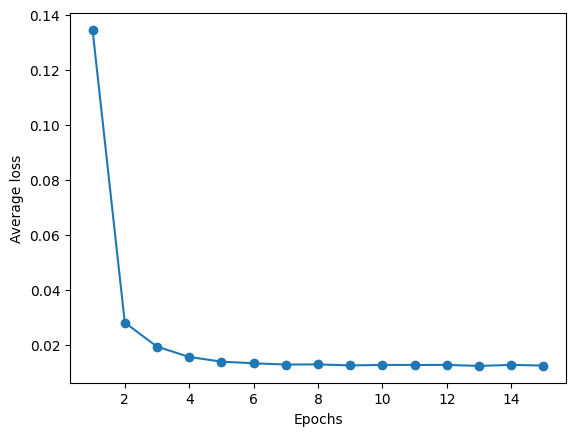

In [54]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y_filtered)

plot_decision_regions(X_std, y_filtered, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')

### 3. Mini-batch SGD Implementation

In [55]:
class AdalineMiniBatchSGD:
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None, batch_size=64):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.w_initialized = False

    def fit(self, X, y):
        """ Fit training data using mini-batch gradient descent."""
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            # Process each mini-batch
            loss = []
            for start in range(0, X.shape[0], self.batch_size):
                end = start + self.batch_size
                X_mini = X[start:end]
                y_mini = y[start:end]
                # Update weights for mini-batch
                tmploss = self._update_weights_mini_batch(X_mini, y_mini)
                loss.append(tmploss)
            self.losses_.append(np.mean(loss))
        return self

    def _update_weights_mini_batch(self, X_mini, y_mini):
        """ Vectorized update for weights using a mini-batch."""
        output = self.activation(self.net_input(X_mini))  # (m, 1) output for mini-batch
        errors = (y_mini - output)  # (m, 1) vector of errors for mini-batch

        # Update weights (Vectorized form)
        self.w_ += self.eta * 2.0 * X_mini.T.dot(errors) / X_mini.shape[0]  # (n, m) dot (m, 1) => (n, 1)
        self.b_ += self.eta * 2.0 * np.sum(errors) / X_mini.shape[0]  # Scalar update for bias

        # Mean squared error for the mini-batch
        loss = np.mean(errors**2)
        return loss

    def _initialize_weights(self, m):
        """Initialize weights."""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _shuffle(self, X, y):
        """Shuffle training data."""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def net_input(self, X):
        """Calculate net input (linear activation)."""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Linear activation (no transformation)."""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

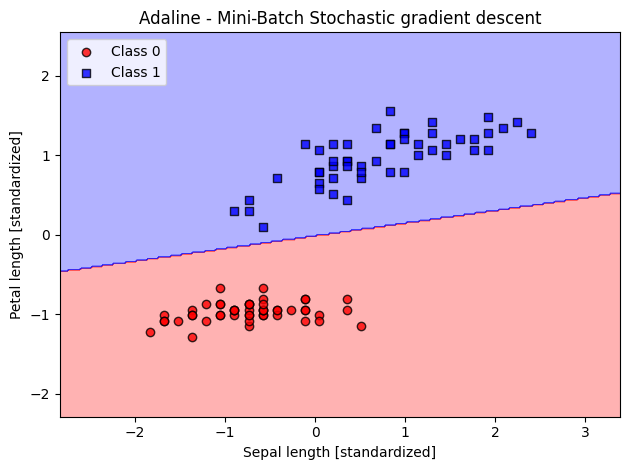

Text(0, 0.5, 'Average loss')

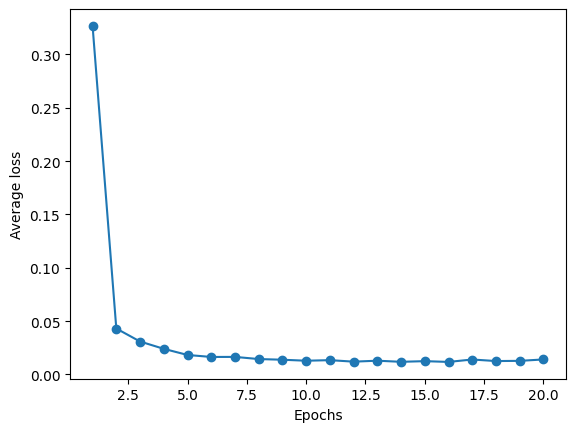

In [56]:
ada_mb_sgd = AdalineMiniBatchSGD(n_iter=20, eta=0.25, random_state=1, batch_size=64)
ada_mb_sgd.fit(X_std, y_filtered)

plot_decision_regions(X_std, y_filtered, classifier=ada_mb_sgd)
plt.title('Adaline - Mini-Batch Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_mb_sgd.losses_) + 1), ada_mb_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')